# Introduction to Text Classification
---


## _Zichen Wang_



## _Ma'ayan Lab Meeting_

## _May 27th, 2016_

---

## 0. Motivations

The [Gene Expression Omnibus (GEO)](http://www.ncbi.nlm.nih.gov/geo/) is arguably the largest repository of gene expression datasets. However, most of the datasets deposited on GEO were not well annotated and classified. Hence we launched crowdsourcing microtasks on the [BD2K-LINCS-DCIC Crowdsourcing Portal](http://maayanlab.net/crowdsourcing/) to recruit humans to read through the descriptions on GEO datasets 

We have collected thousands of gene expression signatures from NCBI's GEO studies. Apart from gene expression data, the crowdsourcing approach also provided us with human labeled text documents in two levels: 
1. GEO study documents (an example: [GSE12609](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE12609)) were labeled as one of the three:  
    1. gene perturbation study
    2. disease study
    3. drug perturbation study

2. GEO sample documents (an example: [GSM315884](http://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM315884)) were labeled as one of the two:
    1. Control
    2. Experimental/Perturbation
    
We can then extract features from the natural languages associated with GSEs and GSMs to predict their labels using classification approaches to scale up the the processes of dataset annotation and signature extraction.

---

## Overview of this presentation/tutorial
1. Prepare some data ([0_prepare_data](0_prepare_data.ipynb))
2. Natural Language Processing Basics
3. Text Classification
    + Applications
    + Defination
    + Methods
        1. Bag-of-words
        2. LSA
        3. Word2vec and Text embedding ([Word2Vec](Word2Vec.ipynb))
        4. Paragraph vector ([Doc2Vec](Doc2vec.ipynb))
        5. ~~RNN? ([RNN](RNN.ipynb))~~

In [1]:
import cPickle as pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
RNG = 2016

# for language processing
from nltk.tokenize import (RegexpTokenizer, WordPunctTokenizer, TreebankWordTokenizer)
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from wordcloud import WordCloud

# for classification
from sklearn.base import clone
from sklearn.metrics import (f1_score, log_loss, accuracy_score)
from sklearn import (naive_bayes, ensemble, svm)
import xgboost as xgb
from sklearn.pipeline import Pipeline
from tensorflow.contrib import learn

# for visualization
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import plotly
plotly.offline.init_notebook_mode() # To embed plots in the output cell of the notebook
import plotly.graph_objs as go

from utils import evaluate_clf

/Library/Python/2.7/site-packages/requests/packages/urllib3/util/ssl_.py:315: SNIMissingWarning: An HTTPS request has been made, but the SNI (Subject Name Indication) extension to TLS is not available on this platform. This may cause the server to present an incorrect TLS certificate, which can cause validation failures. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#snimissingwarning.
  SNIMissingWarning
/Library/Python/2.7/site-packages/requests/packages/urllib3/util/ssl_.py:120: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning


# 1. Natural Language Processing Basics - Text normalizations

##  1.1. Word Tokenization: segmenting words in running text
+ **Token**: a word, phrase, symbol, or other meaningful elements in a running text.
+ Tokenization is not a trival problem:
    + Finland's capital
    + What're, I'm, isn't
    + state-of-the-art
    + Lowercase
    + New York
    + Ph.D
+ Other languages is even harder!
    + **French**: l'ensemble -> un ensemble
    + **German**: Rindfleischetikettierungsueberwachungsaufgabenuebertragungsgesetz, meaning "law delegating beef label monitoring", [the longest German word](http://www.bbc.com/news/world-europe-22762040).
    + **Chinese**: 自然語言處理是人工智慧和語言學領域的分支學科   
    `自然 語言 處理 是 人工 智慧 和 語言學 領域 的 分支 學科`   
    `Natural language processing is artificial intelligence and linguistics 's branch field`

---

_Some of the above examples taken from [Natural Language Processing by Dan Jurafsky and Christopher Manning](https://class.coursera.org/nlp/lecture)_

---

Demonstration of different tokenization algorithms:

In [2]:
example_text = """
Finland's capital, what're, I'm, state-of-the-art New York Ph.D post-injury
"""
for tokenizer in [
    RegexpTokenizer(r"(?u)\b\w\w+\b"), # white space tokenizer
    WordPunctTokenizer(), # tokenize alphabetic and non-alphabetic words
    TreebankWordTokenizer() 
                 ]:
    print '-' * 10
    print tokenizer
    print tokenizer.tokenize(example_text)


----------
RegexpTokenizer(pattern='(?u)\\b\\w\\w+\\b', gaps=False, discard_empty=True, flags=56)
['Finland', 'capital', 'what', 're', 'state', 'of', 'the', 'art', 'New', 'York', 'Ph', 'post', 'injury']
----------
WordPunctTokenizer(pattern=u'\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=56)
['Finland', "'", 's', 'capital', ',', 'what', "'", 're', ',', 'I', "'", 'm', ',', 'state', '-', 'of', '-', 'the', '-', 'art', 'New', 'York', 'Ph', '.', 'D', 'post', '-', 'injury']
----------
['Finland', "'s", 'capital', ',', 'what', "'re", ',', 'I', "'m", ',', 'state-of-the-art', 'New', 'York', 'Ph.D', 'post-injury']


## 1.2. Word normalization
+ **Lemma**: words with the same stem, e.g. `dog` and `dogs`.
+ **Lemmatization**: reduce the variant forms to the base form
    + dogs -> dog
    + am, are, is -> be
+ **Stem**: the core meaning-bearing unit of a word
+ **Stemming**: reduce terms to their stems, a simpler form of Lemmatization.
    + automates, automatic, automation -> automat

+ Differences between **Lemmatization** and **Stemming** [(click to read more)](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)   
**Stemming** returns the stems of words.    
**Lemmatization** returns the dictionary form of word.

---

Demonstration of stemming and Lemmatization:

In [3]:
# load the labeled df we prepared 
df = pd.read_csv('data/Labeled_GSEs_texts_with_labels.csv').set_index('id')
df = df.fillna('')
print df.shape
df.head()

(1785, 5)


,Series_summary,Series_title,label,label_code,split
id,,,,,
GSE1001,Sprague-Dawley rat retina post-injury and cont...,retina injury timecourse,dz,1,0
GSE10064,This study aims to determine if global gene ex...,Gene expression in immortalized B-lymphocytes ...,dz,1,0
GSE10082,Conventional biochemical and molecular techniq...,Aryl Hydrocarbon Receptor Regulates Distinct D...,gene,2,0
GSE1009,Gene expression profiling in glomeruli from hu...,Diabetic nephropathy,dz,1,0
GSE1010,RNA samples prepared from lymphoblastic cells ...,FCHL study,dz,1,0


In [4]:
tokenizer = RegexpTokenizer(r"(?u)\b\w\w+\b") # white space tokenizer

stemmer = PorterStemmer()
lmmr = WordNetLemmatizer()

# get a document from the df
doc = df.ix[1]['Series_summary']
print 'Original document: \n"%s"' % doc

tokens = tokenizer.tokenize(doc)
print '\nAfter tokenizing:', tokens

stems = [stemmer.stem(t) for t in tokens]
print '\nAfter stemming:',  stems

lemmas = [lmmr.lemmatize(t) for t in tokens]
print '\nAfter lemantization:',  lemmas

Original document: 
"This study aims to determine if global gene expression and transcription factor networks in B-lympocytes of siblings with MS were different from healthy siblings. Keywords: Multiple sclerosis, sibling comparisons"

After tokenizing: ['This', 'study', 'aims', 'to', 'determine', 'if', 'global', 'gene', 'expression', 'and', 'transcription', 'factor', 'networks', 'in', 'lympocytes', 'of', 'siblings', 'with', 'MS', 'were', 'different', 'from', 'healthy', 'siblings', 'Keywords', 'Multiple', 'sclerosis', 'sibling', 'comparisons']

After stemming: [u'Thi', u'studi', u'aim', u'to', u'determin', u'if', u'global', u'gene', u'express', u'and', u'transcript', u'factor', u'network', u'in', u'lympocyt', u'of', u'sibl', u'with', u'MS', u'were', u'differ', u'from', u'healthi', u'sibl', u'Keyword', u'Multipl', u'sclerosi', u'sibl', u'comparison']

After lemantization: ['This', 'study', u'aim', 'to', 'determine', 'if', 'global', 'gene', 'expression', 'and', 'transcription', 'factor',

Here we tokenize the texts in the `Series_summary` column

In [5]:
preprocess_func = lambda x: ' '.join( tokenizer.tokenize(x) )
df['Series_summary'] = df['Series_summary'].apply(preprocess_func)
# df['Series_title'] = df['Series_title'].apply(preprocess_func)

(-0.5, 1199.5, 799.5, -0.5)

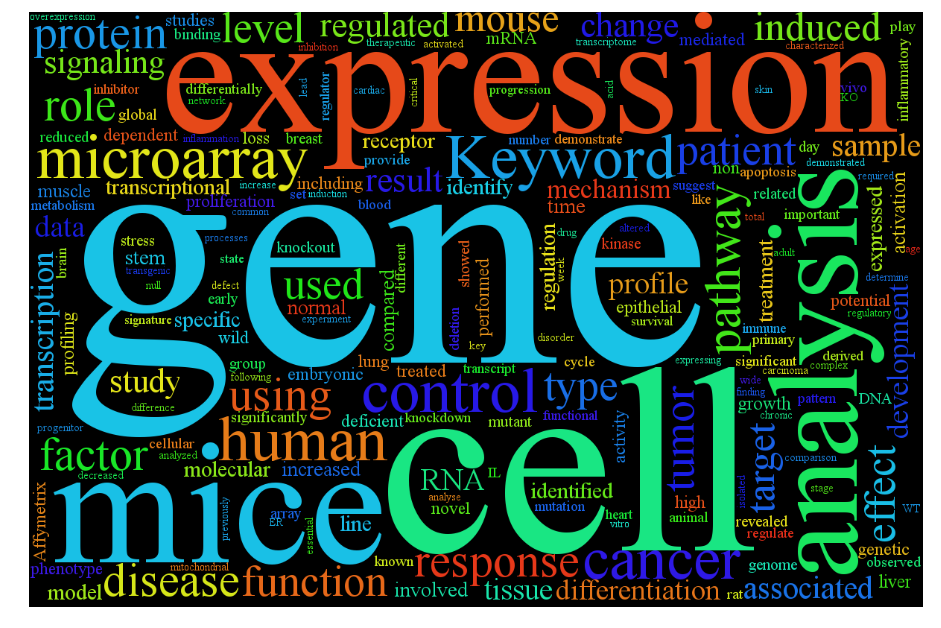

In [6]:
# Visualize the tokens in 'Series_summary' using WordCloud
fig, ax = plt.subplots(figsize=(16,16))
texts = ' '.join(df['Series_summary'].tolist())
wordcloud = WordCloud(width=1200, height=800, stopwords=ENGLISH_STOP_WORDS).generate(texts)
ax.imshow(wordcloud)
ax.axis("off")

# 2. Text classification
+ ## Applications
    1. Email spam detection
    2. Authorship attribution, e.g. Madison, Hamilton, [The Federalist Papers](https://en.wikipedia.org/wiki/The_Federalist_Papers)
    3. Gender identification 
    4. Movie review
    5. Topic of scientific articles
    6. Sentiment analysis

+ ## Defination:
    + Input:
        + a document: `d`
        + a fixed set of classes: `C = {c_1, c_2, ...}`
        + a training set of `m` human-labeled documents: `(d_1,c_1), (d_m, c_m) `
    + Output:
        + a predicted probabilities: `p = (p_1, p_2, ...)` corresponding to the set of classes

+ ## Methods
    1. Bag-of-words
    2. LSA
    3. Text embedding (Word2vec)
    4. Paragraph vector
    5. RNN?


## 2.1. Bag-of-words
+ N-gram: a contiguous sequence of `n` items (tokens) from a given sequence of text:
    + n=1, unigram `[This, study, aim, to, ...]`
    + n=2, bigram `[(This, study), (study aim), (aim, to), ...]`
    + n=3, trigram `[(This, study, aim), (study, aim, to), ...]`
    + ...

+ Use the words/tokens/N-grams and their occurences to represent a document, without preserving the order of words.

+ Naive Bayes classifiers usually have very good predictive performance for word count matrix. 
    - "Naive": assumes features are independent.
    
+ Two forms of Naive Bayes are suitable for this probelm
    - [BernoulliNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB): based multivariate Bernoulli distribution (features are binary values). It explicitly penalizes the non-occurrence of a feature. It takes binarized word count matrix as input. Might perform better on short documents.
    
    - [MultinomialNB](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB): based on multinominal distribution. It takes word count matrix as input.

To learn more about Naive Bayes classifiers:   
http://scikit-learn.org/stable/modules/naive_bayes.html  
http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.61.5542

--- 
Below we use [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to count the words in each document and generate a sparse word count matrix with the shape = (n_documents, n_tokens)

In [7]:
# count tokens 
ctvec = CountVectorizer(min_df=1,
                        max_df=1000, # max document frequency, words with higher frequency than this will be ignored  
                        max_features=None, 
                        strip_accents='unicode', 
                        decode_error='ignore',
                        lowercase=True,
                        tokenizer=None,
                        analyzer='word', 
                        ngram_range=(1, 2), # keep uni-grams and di-grams
                        binary=True, # whether to return binary numbers or word counts
                        stop_words='english')

X = ctvec.fit_transform(df['Series_summary'])
print type(X)
print X.shape 

<class 'scipy.sparse.csr.csr_matrix'>
(1785, 115701)


In [8]:
# a mapping of terms to feature indices can be find in CountVectorizer.vocabulary_
print ctvec.vocabulary_.items()[:5] 

[(u'loss htra2', 63377), (u'invasion rna', 57370), (u'tumors women', 110390), (u'gene associated', 44266), (u'localizes', 63156)]


We first use BernoulliNB on the binarized word count matrix

In [9]:
clf = naive_bayes.BernoulliNB()
y = df['label_code'].values

scores = evaluate_clf(clf, X, y, df['split'])
print scores.mean(axis=0)

f1           0.476865
accuracy     0.612329
logloss     13.247696
dtype: float64


/Library/Python/2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning:

F-score is ill-defined and being set to 0.0 in labels with no predicted samples.



In [10]:
# BernoulliNB's performance on titles
X_title = ctvec.fit_transform(df['Series_title'])
print X_title.shape
clf = naive_bayes.BernoulliNB()
scores = evaluate_clf(clf, X_title, y, df['split'])
print scores.mean(axis=0)

(1785, 14184)
f1          0.466350
accuracy    0.609528
logloss     9.131339
dtype: float64


In [11]:
# count tokens 
ctvec2 = CountVectorizer(min_df=1,
                        max_df=1000, # max document frequency, words with higher frequency than this will be ignored  
                        max_features=None, 
                        strip_accents='unicode', 
                        decode_error='ignore',
                        lowercase=True,
                        tokenizer=None,
                        analyzer='word', 
                        ngram_range=(1, 2),
                        binary=False, # whether to return binary numbers or word counts
                        stop_words='english')

X = ctvec2.fit_transform(df['Series_summary'])
print X.shape

(1785, 115701)


In [12]:
clf = naive_bayes.MultinomialNB()

scores = evaluate_clf(clf, X, y, df['split'])
print scores.mean(axis=0)

f1          0.795405
accuracy    0.807280
logloss     3.095285
dtype: float64


In [13]:
# MultinomialNB's performance on titles
X_title = ctvec2.fit_transform(df['Series_title'])
clf = naive_bayes.MultinomialNB()
scores = evaluate_clf(clf, X_title, y, df['split'])
print scores.mean(axis=0)

f1          0.729664
accuracy    0.739487
logloss     0.887691
dtype: float64


### TF-IDF: term frequency–inverse document frequency

To weight the term frequency (word count) in a document by the inverse of term frequency in a collection of documents. Intends to normalize the word importance in a document to the collection of documents.

---
## 2.2. Latent semantic analysis (LSA)

A technique of analyzing relationships between a set of documents and the terms they contain by producing a set of concepts related to the documents and terms.

It uses Singular Value Decomposition (SVD) to reduce the dimentionality of the document-by-word or word-by-document matrix to compare documents or words similarities in low-dimentional space.

---
Scripts below uses of SVD to reduce the dimentionality of the TF-IDF document-by-word matrix. Then classifiers can be learned on the latent semantic matrix.

In [14]:
tfidf = TfidfVectorizer(min_df=1, max_df=1000, 
                        max_features=None, strip_accents='unicode', 
                        decode_error='ignore',
                        analyzer='word', 
                        ngram_range=(1, 2), 
                        use_idf=True, smooth_idf=True, 
                        sublinear_tf=True, stop_words = 'english')
svd = TruncatedSVD(n_components=90, algorithm='randomized', n_iter=5, random_state=RNG, tol=0.0)

pipeline = Pipeline([
        ('tfidf', tfidf),
        ('svd', svd)
    ])

X = pipeline.fit_transform(df['Series_summary'])
print X.shape

(1785, 90)


#### Use t-SNE to embed and visualize the LSA matrix 

In [15]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
coords = tsne.fit_transform(X)
print coords.shape

(1785, 2)


In [16]:
# Scatter plot the t-SNE embedding of the LSA
data =[]
for label in df['label'].unique():
    mask = np.where(df['label'] == label)[0]
    trace = go.Scatter(
        x=coords[mask, 0],
        y=coords[mask, 1],
        text=df.iloc[mask]['Series_title'],
        mode='markers',
        marker=dict(
            size=5,
            opacity=.5,
        ),
        name=label
    )
    data.append(trace)
    
# Configs for layout and axes
layout=dict(height=800, width=800, 
            title='t-SNE embedding of the documents in LSA space',
            hovermode='closest',
            scene=dict(
                xaxis=dict(title='M1', zeroline=False),
                yaxis=dict(title='M2', zeroline=False),
               )
)
fig=dict(data=data, layout=layout)
plotly.offline.iplot(fig)

#### Make classifiers for text classification using the document embedding matrix

In [18]:
# a simple 2-layered Deep Neural Network
dnn = learn.TensorFlowDNNClassifier(hidden_units=[100, 10], n_classes=3,
    steps=500, learning_rate=0.01, batch_size=128)

scores = evaluate_clf(dnn, X, y, df['split'])
print scores.mean(axis=0)

Step #100, epoch #10, avg. train loss: 1.59786
Step #200, epoch #20, avg. train loss: 0.94959
Step #300, epoch #30, avg. train loss: 0.90829
Step #400, epoch #40, avg. train loss: 0.90371
Step #500, epoch #50, avg. train loss: 0.89612
Step #100, epoch #10, avg. train loss: 1.59985
Step #200, epoch #20, avg. train loss: 0.95162
Step #300, epoch #30, avg. train loss: 0.91055
Step #400, epoch #40, avg. train loss: 0.89911
Step #500, epoch #50, avg. train loss: 0.89264
Step #100, epoch #10, avg. train loss: 1.59705
Step #200, epoch #20, avg. train loss: 0.95184
Step #300, epoch #30, avg. train loss: 0.90978
Step #400, epoch #40, avg. train loss: 0.90532
Step #500, epoch #50, avg. train loss: 0.89488
f1          0.456159
accuracy    0.605043
logloss     0.893719
dtype: float64


In [17]:
# a Gradient Boosting classifier
xgbc = xgb.XGBClassifier(n_estimators=1000, colsample_bytree=0.8, 
                         learning_rate=0.05, max_depth=8, subsample=0.9, 
                         min_child_weight=1, seed=RNG, nthread=4, silent=0)

scores = evaluate_clf(xgbc, X, y, df['split'])
print scores.mean(axis=0)

f1          0.809409
accuracy    0.817359
logloss     0.599191
dtype: float64


In [18]:
# More classifiers 
rf = ensemble.RandomForestClassifier(n_estimators=2000, criterion='entropy', 
                                     max_depth=None, random_state=RNG, n_jobs=4, verbose=0)
et = ensemble.ExtraTreesClassifier(n_estimators=1500, criterion='entropy', max_depth=None, 
                                   random_state=RNG, n_jobs=4, verbose=0)
svc = svm.SVC(C=100, kernel='rbf', probability=True, random_state=RNG, verbose=0)

for clf in [rf, et, svc]:
    scores = evaluate_clf(clf, X, y, df['split'])
    print '-' * 10
    print clf
    print scores.mean(axis=0)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=4,
            oob_score=False, random_state=2016, verbose=0,
            warm_start=False)
f1          0.751212
accuracy    0.777590
logloss     0.617417
dtype: float64
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1500, n_jobs=4,
           oob_score=False, random_state=2016, verbose=0, warm_start=False)
f1          0.705742
accuracy    0.745646
logloss     0.780250
dtype: float64
SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter

In [20]:
# democratic voting of the 4 classifiers
voter = ensemble.VotingClassifier(estimators=[('rf', rf), ('et', et), ('svc', svc), ('xgbc', xgbc)], voting='soft')
scores = evaluate_clf(voter, X, y, df['split'])
print scores.mean(axis=0)

f1          0.814293
accuracy    0.823525
logloss     0.493696
dtype: float64
